In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation/Models/GDSC_PDX_TCGA_Second_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation/Models/GDSC_PDX_TCGA_Second_Strategy/Second_Strategy_Finetuned_Models//"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
paclitaxel_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi/Paclitaxel/"
pathfindR_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation/pathfindR/GDSC_PDX_TCGA_Second_Strategy/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation/Figures/GDSC_PDX_TCGA_Second_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC expression dataset (MITOSISi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [5]:
# read GDSC expression dataset (MITOSISi)

GDSCE = pd.read_csv("GDSC_exprs.z.MITOSISi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [6]:
# change directory to read GDSC mutation dataset (MITOSISi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [7]:
# read GDSC mutation dataset (MITOSISi)

GDSCM = pd.read_csv("GDSC_mutations.MITOSISi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# change directory to read GDSC response dataset (MITOSISi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [9]:
# read GDSC response dataset (MITOSISi)

GDSCR = pd.read_csv("GDSC_response.MITOSISi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = GDSCR.loc[GDSCR["drug"] != "Paclitaxel", ]

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1
683665,0,-1.86219201025588,BI-2536,1,1,1
683665,0,-3.03887798334128,GW843682X,1,1,1
683665,0,-3.71615762180145,SB-715992,1,1,1


In [10]:
# print count of cell lines for each drug (MITOSISi)

GDSCR["drug"].value_counts()

drug
Genentech Cpd 10       771
SB-715992              770
NPK76-II-72-1          769
MPS-1-IN-1             767
GSK1070916             747
ZM-447439              694
GW843682X              370
S-Trityl-L-cysteine    369
BI-2536                368
VX-680                 365
Name: count, dtype: int64

In [11]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Paclitaxel)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [12]:
# read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

PDXEpaclitaxel = pd.read_csv("PDX_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEpaclitaxel = pd.DataFrame.transpose(PDXEpaclitaxel)
PDXEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1008,5.1683455924601,6.40148605928778,5.14735257900894,2.62182669498089,5.65801642244848,2.56126582112594,7.9002150761815,2.99037104024989,9.07138836072349,2.93107188443328,...,2.51273514040916,3.16885840754458,7.88710414124411,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,3.95569877310649,3.86826539821721,2.24540260166309
X-1156,5.64285976724198,6.16403060339034,6.56682953977831,2.62182669498089,2.20555612143949,2.68000643826337,8.28747895280708,2.40648953950849,6.85807798266578,3.44682372154383,...,2.6201404525098,3.05224139425924,6.43259864910441,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,5.32315076936616,3.85690425090814,2.27121625384186
X-1172,2.76326591576383,6.63737682195879,5.67675838505579,2.79473965144091,3.52596051559272,5.74258764261314,8.70184553811941,2.66283398075993,9.95397018105127,3.64884172474159,...,2.68566229198938,3.11779249946595,5.44497097056128,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,2.45399733779172,4.19271392722119,2.21127349569176


In [13]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Paclitaxel)

TCGAEpaclitaxel = pd.read_csv("TCGA_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEpaclitaxel = pd.DataFrame.transpose(TCGAEpaclitaxel)
TCGAEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-50-5068-01A,6.07077606939576,4.22435549873448,6.09703453175451,2.79409553041956,2.16511492655888,6.23897149546054,7.50971824388108,2.62136482478483,6.78739521681224,2.98021984531206,...,9.80444787373941,2.79886640790268,2.81581286530484,3.00085815257311,2.80511713535762,2.40148864399763,2.58029798170468,3.80309726320581,2.93775838077045,3.15136733303223
TCGA-53-7624-01A,3.36417856158271,1.84257380220382,4.89461611130517,3.01203072800212,1.08675483906125,2.65397613649159,8.19887134647799,2.64492131772784,9.57693655417731,2.75400746416671,...,9.87655475612095,2.79886640790268,2.81581286530484,3.47072364084828,2.92631228926461,3.04342978048926,3.85945702517433,2.76860237341666,4.70753879715127,4.40422733195751
TCGA-99-8033-01A,3.17759663469389,4.069358321802,5.30291306958158,3.04306111581331,1.71759129803103,2.9492322528108,8.35388516673678,2.61215713067395,9.55148283225251,2.62363654845594,...,9.97545462791267,2.79886640790268,2.81581286530484,3.61434933029633,2.82800183535407,2.62335146413649,2.82601101115657,2.76860237341666,4.83367880098437,4.96091320806586


In [14]:
# change directory to read PDX mutation dataset (Paclitaxel)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [15]:
# read PDX mutation dataset (Paclitaxel)

PDXMpaclitaxel = pd.read_csv("PDX_mutations.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMpaclitaxel.drop_duplicates(keep='last')
PDXMpaclitaxel = pd.DataFrame.transpose(PDXMpaclitaxel)
PDXMpaclitaxel = PDXMpaclitaxel.loc[:, ~PDXMpaclitaxel.columns.duplicated()]

PDXMpaclitaxel.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1008,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1156,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,-0.05,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1172,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# read TCGA mutation dataset (Paclitaxel)

TCGAMpaclitaxel = pd.read_csv("TCGA_mutations.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMpaclitaxel.drop_duplicates(keep='last')
TCGAMpaclitaxel = pd.DataFrame.transpose(TCGAMpaclitaxel)
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[:, ~TCGAMpaclitaxel.columns.duplicated()]

TCGAMpaclitaxel.head(3)

,1,2,9,10,12,13,14,15,16,18,...,101929762,101929950,102723701,102724473,102724536,104472715,105375355,106478954,107075310,107161144
TCGA-50-5068-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7624-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-99-8033-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# variance threshold for GDSC expression dataset (MITOSISi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [18]:
# fill NA values and binarize GDSC mutation dataset (MITOSISi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [19]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEpaclitaxel.columns)
ls = ls.intersection(PDXMpaclitaxel.columns)
ls = ls.intersection(TCGAEpaclitaxel.columns)
ls = ls.intersection(TCGAMpaclitaxel.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 13828


In [20]:
# select shared samples between GDSC expression, mutation, and response datasets (MITOSISi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 799


In [21]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

# There exists same sample names for different drugs, so row shape is different in GDSC response data

GDSC # of common samples and genes (Expression): (799, 13828)
GDSC # of common samples and genes (Mutation): (799, 13828)
GDSC # of samples (Response): 5990


In [22]:
# select shared samples between PDX expression and mutation datasets (Paclitaxel) 

ls3 = PDXEpaclitaxel.index.intersection(PDXMpaclitaxel.index)

print(f"PDX # of common samples (Paclitaxel): {ls3.shape[0]}")

PDX # of common samples (Paclitaxel): 43


In [23]:
# select shared samples between TCGA expression and mutation datasets (Paclitaxel) 

ls4 = TCGAEpaclitaxel.index.intersection(TCGAMpaclitaxel.index)

print(f"TCGA # of common samples (Paclitaxel): {ls4.shape[0]}")

TCGA # of common samples (Paclitaxel): 35


In [24]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (Paclitaxel)

PDXEpaclitaxel = PDXEpaclitaxel.loc[ls3, ls]
PDXMpaclitaxel = PDXMpaclitaxel.loc[ls3, ls]

TCGAEpaclitaxel = TCGAEpaclitaxel.loc[ls4, ls]
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Paclitaxel): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Mutation (Paclitaxel): {PDXMpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Paclitaxel): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Mutation (Paclitaxel): {TCGAMpaclitaxel.shape}")

PDX # of common samples and genes for Expression (Paclitaxel): (43, 13828)
PDX # of common samples and genes for Mutation (Paclitaxel): (43, 13828)

TCGA # of common samples and genes for Expression (Paclitaxel): (35, 13828)
TCGA # of common samples and genes for Mutation (Paclitaxel): (35, 13828)


In [25]:
# change directory to read DEGs (MITOSISi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi


In [26]:
# read DEGs (MITOSISi)

DEGs_filtered_data = pd.read_excel("MITOSISi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among mitotic inhibitors\n")

DEGs_filtered_data.head()

There are 996 DEGs (p-adjusted < 0.05 and |logFC| > 1) among mitotic inhibitors



,Gene Symbol,Frequency
0,PLS3,8
1,GMFG,7
2,GPRC5A,7
3,TJP1,7
4,CXCR4,7


In [27]:
# subset only DEGs with Frequency = 1

filter = DEGs_filtered_data["Frequency"] == 1
DEGs_freq_one =  DEGs_filtered_data[filter]
DEGs_freq_one.head()

,Gene Symbol,Frequency
599,SEC11C,1
600,BHLHE40,1
601,FAM20C,1
602,HCFC1R1,1
603,CD247,1


In [28]:
# read DEGs (Paclitaxel) and select paclitaxel-unique DEGs

DEGs_paclitaxel_data = pd.read_excel("MITOSISi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                     sheet_name = "Paclitaxel")

filter = DEGs_paclitaxel_data["Gene.Symbol"].isin(DEGs_freq_one["Gene Symbol"])
only_paclitaxel_degs = DEGs_paclitaxel_data.loc[filter, "Gene.Symbol"]

print(f'There are {only_paclitaxel_degs.shape[0]} DEGs unique to Paclitaxel, so they were removed from the DEGs list')

There are 29 DEGs unique to Paclitaxel, so they were removed from the DEGs list


In [29]:
# remove paclitaxel-unique DEGs from feature set (MITOSISi)

filter = DEGs_filtered_data["Gene Symbol"].isin(only_paclitaxel_degs)
DEGs_filtered_data = DEGs_filtered_data[~filter]

DEGs_filtered_data.head()

,Gene Symbol,Frequency
0,PLS3,8
1,GMFG,7
2,GPRC5A,7
3,TJP1,7
4,CXCR4,7


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CAST', 2), ('CLECL1P', 2)]
1 input query terms found no hit:	['SLC22A18']


967

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1
683665,0,-1.86219201025588,BI-2536,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'BI-2536',
 'GSK1070916',
 'GW843682X',
 'Genentech Cpd 10',
 'MPS-1-IN-1',
 'NPK76-II-72-1',
 'S-Trityl-L-cysteine',
 'SB-715992',
 'VX-680',
 'ZM-447439'}

In [34]:
# convert Entrez gene IDs to integer

GDSCE.index = GDSCE.index.astype(str)
GDSCM.index = GDSCM.index.astype(str)
responses.index = responses.index.astype(str)

In [35]:
# filter GDSC expression and mutation datasets (MITOSISi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls5]
PDXMpaclitaxel = PDXMpaclitaxel.loc[:,ls5]
TCGAEpaclitaxel = TCGAEpaclitaxel.loc[:,ls5]
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (Mutation): {PDXMpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Paclitaxel (Expression): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (Mutation): {TCGAMpaclitaxel.shape}")

GDSC # of common samples and genes (Expression): (5990, 817)
GDSC # of common samples and genes (Mutation): (5990, 817)
GDSC # of common samples (Response): 5990

PDX # of common samples and genes for Paclitaxel (Expression): (43, 817)
PDX # of common samples and genes for Paclitaxel (Mutation): (43, 817)

TCGA # of common samples and genes for Paclitaxel (Expression): (35, 817)
TCGA # of common samples and genes for Paclitaxel (Mutation): (35, 817)


In [36]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 1]


In [37]:
# change directory to read PDX and TCGA response datasets (Paclitaxel)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [38]:
# read PDX response dataset (Paclitaxel)

PDXRpaclitaxel = pd.read_csv("PDX_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRpaclitaxel.dropna(inplace=True)
PDXRpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRpaclitaxel["response"] = PDXRpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel_pdx = PDXRpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel_pdx.shape[0]} samples with response data in the PDX (Paclitaxel)\n")
Ytspaclitaxel_pdx

There are 43 samples with response data in the PDX (Paclitaxel)



array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [39]:
# read PDX dataset to select cohorts (Paclitaxel)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "paclitaxel",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-1004,BRCA
X-1008,BRCA
X-1156,NSCLC
X-1172,NSCLC
X-1189,NSCLC


In [40]:
# merged PDX cohort table with PDX response dataset (Paclitaxel)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRpaclitaxel,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
BRCA     24
NSCLC    19
Name: count, dtype: int64

In [41]:
# filter BRCA cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "BRCA")
pdx_brca_samples = dat_pdx.loc[filter,].index
pdx_brca_samples

Index(['X-1008', 'X-1298', 'X-1371', 'X-1383', 'X-1407', 'X-1468', 'X-1600',
       'X-1916', 'X-1921', 'X-2195', 'X-2344', 'X-2487', 'X-2524', 'X-2780',
       'X-3298', 'X-3450', 'X-3873', 'X-4347', 'X-4567', 'X-4824', 'X-4949',
       'X-5502', 'X-5975', 'X-6047'],
      dtype='object')

In [42]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_pdx_brca = PDXRpaclitaxel.loc[pdx_brca_samples,"response"].values
Ytspaclitaxel_pdx_brca

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0])

In [43]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

PDXRpaclitaxel.loc[pdx_brca_samples,"response"].value_counts()

response
0    19
1     5
Name: count, dtype: int64

In [44]:
# filter NSCLC cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1787',
       'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980', 'X-1993', 'X-2017',
       'X-2042', 'X-2082', 'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [45]:
# filter responses of NSCLC cohort samples (Paclitaxel)

Ytspaclitaxel_nsclc = PDXRpaclitaxel.loc[pdx_nsclc_samples,"response"].values
Ytspaclitaxel_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
# read TCGA response dataset (Paclitaxel)

TCGARpaclitaxel = pd.read_csv("TCGA_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARpaclitaxel.dropna(inplace=True)
TCGARpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARpaclitaxel["response"] = TCGARpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel_tcga = TCGARpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel_tcga.shape[0]} samples with response data in the TCGA (Paclitaxel)\n")
Ytspaclitaxel_tcga

There are 35 samples with response data in the TCGA (Paclitaxel)



array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [47]:
# TCGA cohort table with TCGA response dataset (Paclitaxel)

dat_tcga = TCGARpaclitaxel["cohort"]

dat_tcga.value_counts()

cohort
BRCA    27
LUAD     3
UCS      3
STAD     1
HNSC     1
Name: count, dtype: int64

In [48]:
# filter BRCA cohort samples (Paclitaxel)

filter = (TCGARpaclitaxel["cohort"] == "BRCA")
tcga_brca_samples = dat_tcga.loc[filter,].index
tcga_brca_samples

Index(['TCGA-A2-A0EP-01A', 'TCGA-A2-A3XS-01A', 'TCGA-A2-A3XW-01A',
       'TCGA-A2-A3XX-01A', 'TCGA-A2-A3XY-01A', 'TCGA-A2-A4S2-01A',
       'TCGA-A7-A4SA-01A', 'TCGA-A7-A4SE-01A', 'TCGA-A7-A5ZV-01A',
       'TCGA-A7-A5ZX-01A', 'TCGA-A8-A08X-01A', 'TCGA-A8-A09M-01A',
       'TCGA-AQ-A54O-01A', 'TCGA-B6-A402-01A', 'TCGA-D8-A3Z6-01A',
       'TCGA-EW-A1OY-01A', 'TCGA-EW-A1P3-01A', 'TCGA-EW-A2FR-01A',
       'TCGA-GM-A2DA-01A', 'TCGA-GM-A2DB-01A', 'TCGA-GM-A2DF-01A',
       'TCGA-GM-A2DH-01A', 'TCGA-GM-A2DM-01A', 'TCGA-GM-A2DN-01A',
       'TCGA-GM-A3XG-01A', 'TCGA-GM-A3XL-01A', 'TCGA-GM-A3XN-01A'],
      dtype='object', name='sample')

In [49]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_tcga_brca = TCGARpaclitaxel.loc[tcga_brca_samples,"response"].values
Ytspaclitaxel_tcga_brca

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1])

In [50]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

TCGARpaclitaxel.loc[tcga_brca_samples,"response"].value_counts()

response
1    22
0     5
Name: count, dtype: int64

In [51]:
# maximum iteration

max_iter = 50

In [52]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 64
hdm2 = 32
rate1 = 0.5
rate2 = 0.6
rate3 = 0.6

In [53]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEpaclitaxel_pdx = scalerGDSC.transform(PDXEpaclitaxel.values) 
X_testEpaclitaxel_pdx_brca = scalerGDSC.transform(PDXEpaclitaxel.loc[pdx_brca_samples,].values) 

X_testEpaclitaxel_tcga = scalerGDSC.transform(TCGAEpaclitaxel.values)    
X_testEpaclitaxel_tcga_brca = scalerGDSC.transform(TCGAEpaclitaxel.loc[tcga_brca_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMpaclitaxel_pdx = np.nan_to_num(PDXMpaclitaxel.values.astype(np.float32))
X_testMpaclitaxel_pdx_brca = np.nan_to_num(PDXMpaclitaxel.loc[pdx_brca_samples,].values.astype(np.float32))
X_testMpaclitaxel_tcga = np.nan_to_num(TCGAMpaclitaxel.values.astype(np.float32))
X_testMpaclitaxel_tcga_brca = np.nan_to_num(TCGAMpaclitaxel.loc[tcga_brca_samples,].values.astype(np.float32))

TX_testEpaclitaxel_pdx = torch.FloatTensor(X_testEpaclitaxel_pdx)
TX_testEpaclitaxel_pdx_brca = torch.FloatTensor(X_testEpaclitaxel_pdx_brca)

TX_testMpaclitaxel_pdx = torch.FloatTensor(X_testMpaclitaxel_pdx.astype(np.float32))
TX_testMpaclitaxel_pdx_brca = torch.FloatTensor(X_testMpaclitaxel_pdx_brca.astype(np.float32))

ty_testEpaclitaxel_pdx = torch.FloatTensor(Ytspaclitaxel_pdx.astype(int))
ty_testEpaclitaxel_pdx_brca = torch.FloatTensor(Ytspaclitaxel_pdx_brca.astype(int))

TX_testEpaclitaxel_tcga = torch.FloatTensor(X_testEpaclitaxel_tcga)
TX_testEpaclitaxel_tcga_brca = torch.FloatTensor(X_testEpaclitaxel_tcga_brca)

TX_testMpaclitaxel_tcga = torch.FloatTensor(X_testMpaclitaxel_tcga.astype(np.float32))
TX_testMpaclitaxel_tcga_brca = torch.FloatTensor(X_testMpaclitaxel_tcga_brca.astype(np.float32))

ty_testEpaclitaxel_tcga = torch.FloatTensor(Ytspaclitaxel_tcga.astype(int))
ty_testEpaclitaxel_tcga_brca = torch.FloatTensor(Ytspaclitaxel_tcga_brca.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy.pt")

Clas = torch.load(models_dir + "Class_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETpaclitaxel_pdx = AutoencoderE(TX_testEpaclitaxel_pdx)
ZMTpaclitaxel_pdx = AutoencoderM(TX_testMpaclitaxel_pdx)
ZTTpaclitaxel_pdx = torch.cat((ZETpaclitaxel_pdx, ZMTpaclitaxel_pdx), 1)
ZTTpaclitaxel_pdx = F.normalize(ZTTpaclitaxel_pdx, p=2, dim=0)
PredTpaclitaxel_pdx = Clas(ZTTpaclitaxel_pdx)
AUCTpaclitaxel_pdx = roc_auc_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
AUCTpaclitaxel_pdx_aucpr = average_precision_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())

ZETpaclitaxel_pdx_brca = AutoencoderE(TX_testEpaclitaxel_pdx_brca)
ZMTpaclitaxel_pdx_brca = AutoencoderM(TX_testMpaclitaxel_pdx_brca)
ZTTpaclitaxel_pdx_brca = torch.cat((ZETpaclitaxel_pdx_brca, ZMTpaclitaxel_pdx_brca), 1)
ZTTpaclitaxel_pdx_brca = F.normalize(ZTTpaclitaxel_pdx_brca, p=2, dim=0)
PredTpaclitaxel_pdx_brca = Clas(ZTTpaclitaxel_pdx_brca)
AUCTpaclitaxel_pdx_brca = roc_auc_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
AUCTpaclitaxel_pdx_brca_aucpr = average_precision_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())

ZETpaclitaxel_tcga = AutoencoderE(TX_testEpaclitaxel_tcga)
ZMTpaclitaxel_tcga = AutoencoderM(TX_testMpaclitaxel_tcga)
ZTTpaclitaxel_tcga = torch.cat((ZETpaclitaxel_tcga, ZMTpaclitaxel_tcga), 1)
ZTTpaclitaxel_tcga = F.normalize(ZTTpaclitaxel_tcga, p=2, dim=0)
PredTpaclitaxel_tcga = Clas(ZTTpaclitaxel_tcga)
AUCTpaclitaxel_tcga = roc_auc_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
AUCTpaclitaxel_tcga_aucpr = average_precision_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())

ZETpaclitaxel_tcga_brca = AutoencoderE(TX_testEpaclitaxel_tcga_brca)
ZMTpaclitaxel_tcga_brca = AutoencoderM(TX_testMpaclitaxel_tcga_brca)
ZTTpaclitaxel_tcga_brca = torch.cat((ZETpaclitaxel_tcga_brca, ZMTpaclitaxel_tcga_brca), 1)
ZTTpaclitaxel_tcga_brca = F.normalize(ZTTpaclitaxel_tcga_brca, p=2, dim=0)
PredTpaclitaxel_tcga_brca = Clas(ZTTpaclitaxel_tcga_brca)
AUCTpaclitaxel_tcga_brca = roc_auc_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())
AUCTpaclitaxel_tcga_brca_aucpr = average_precision_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTpaclitaxel_pdx_finetuned = dict()
AUCTpaclitaxel_tcga_finetuned = dict()
AUCTpaclitaxel_pdx_brca_finetuned = dict()
AUCTpaclitaxel_tcga_brca_finetuned = dict()
AUCTpaclitaxel_pdx_aucpr_finetuned = dict()
AUCTpaclitaxel_tcga_aucpr_finetuned = dict()
AUCTpaclitaxel_pdx_brca_aucpr_finetuned = dict()
AUCTpaclitaxel_tcga_brca_aucpr_finetuned = dict()
for iter in range(max_iter):
    iter += 1  
 
    AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
    AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
    Clas_finetuned = torch.load(finetuned_dir + f"Class_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
    
    AutoencoderE_finetuned.eval()
    AutoencoderM_finetuned.eval()
    Clas_finetuned.eval()
       
    ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
    ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
    ZTX = torch.cat((ZEX, ZMX), 1)
    ZTX = F.normalize(ZTX, p=2, dim=0)
    PredX = Clas_finetuned(ZTX)
    AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
    AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
    
    ZETpaclitaxel_pdx = AutoencoderE_finetuned(TX_testEpaclitaxel_pdx)
    ZMTpaclitaxel_pdx = AutoencoderM_finetuned(TX_testMpaclitaxel_pdx)
    ZTTpaclitaxel_pdx = torch.cat((ZETpaclitaxel_pdx, ZMTpaclitaxel_pdx), 1)
    ZTTpaclitaxel_pdx = F.normalize(ZTTpaclitaxel_pdx, p=2, dim=0)
    PredTpaclitaxel_pdx = Clas_finetuned(ZTTpaclitaxel_pdx)
    AUCTpaclitaxel_pdx_finetuned[iter] = roc_auc_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
    AUCTpaclitaxel_pdx_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
 
    ZETpaclitaxel_pdx_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_pdx_brca)
    ZMTpaclitaxel_pdx_brca = AutoencoderM_finetuned(TX_testMpaclitaxel_pdx_brca)
    ZTTpaclitaxel_pdx_brca = torch.cat((ZETpaclitaxel_pdx_brca, ZMTpaclitaxel_pdx_brca), 1)
    ZTTpaclitaxel_pdx_brca = F.normalize(ZTTpaclitaxel_pdx_brca, p=2, dim=0)
    PredTpaclitaxel_pdx_brca = Clas_finetuned(ZTTpaclitaxel_pdx_brca)
    AUCTpaclitaxel_pdx_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
    AUCTpaclitaxel_pdx_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
 
    ZETpaclitaxel_tcga = AutoencoderE_finetuned(TX_testEpaclitaxel_tcga)
    ZMTpaclitaxel_tcga = AutoencoderM_finetuned(TX_testMpaclitaxel_tcga)
    ZTTpaclitaxel_tcga = torch.cat((ZETpaclitaxel_tcga, ZMTpaclitaxel_tcga), 1)
    ZTTpaclitaxel_tcga = F.normalize(ZTTpaclitaxel_tcga, p=2, dim=0)
    PredTpaclitaxel_tcga = Clas_finetuned(ZTTpaclitaxel_tcga)
    AUCTpaclitaxel_tcga_finetuned[iter] = roc_auc_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
    AUCTpaclitaxel_tcga_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
 
    ZETpaclitaxel_tcga_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_tcga_brca)
    ZMTpaclitaxel_tcga_brca = AutoencoderM_finetuned(TX_testMpaclitaxel_tcga_brca)
    ZTTpaclitaxel_tcga_brca = torch.cat((ZETpaclitaxel_tcga_brca, ZMTpaclitaxel_tcga_brca), 1)
    ZTTpaclitaxel_tcga_brca = F.normalize(ZTTpaclitaxel_tcga_brca, p=2, dim=0)
    PredTpaclitaxel_tcga_brca = Clas_finetuned(ZTTpaclitaxel_tcga_brca)
    AUCTpaclitaxel_tcga_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())
    AUCTpaclitaxel_tcga_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())

max_key_pdx = max(AUCTpaclitaxel_pdx_aucpr_finetuned, key=AUCTpaclitaxel_pdx_aucpr_finetuned.get)
max_key_pdx_brca = max(AUCTpaclitaxel_pdx_brca_aucpr_finetuned, key=AUCTpaclitaxel_pdx_brca_aucpr_finetuned.get)
max_key_tcga = max(AUCTpaclitaxel_tcga_aucpr_finetuned, key=AUCTpaclitaxel_tcga_aucpr_finetuned.get)
max_key_tcga_brca = max(AUCTpaclitaxel_tcga_brca_aucpr_finetuned, key=AUCTpaclitaxel_tcga_brca_aucpr_finetuned.get)

print(f"GDSC - Training AUC (MITOSISi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (MITOSISi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel_pdx,2)}")
print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca,2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel): {round(AUCTpaclitaxel_tcga,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca_aucpr,2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key_pdx_brca],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_brca],2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_pdx_brca_finetuned[max_key_pdx_brca],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_pdx_brca_aucpr_finetuned[max_key_pdx_brca],2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key_tcga_brca],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_brca],2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_tcga_brca_finetuned[max_key_tcga_brca],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_tcga_brca_aucpr_finetuned[max_key_tcga_brca],2)}\n\n")

print("Models for maximum finetuning (Paclitaxel, PDX)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Paclitaxel, PDX, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_brca}.pt")
print(f"Mut_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_brca}.pt")

print("\nModels for maximum finetuning (Paclitaxel, TCGA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Paclitaxel, TCGA, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_brca}.pt")
print(f"Mut_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_MITOSISi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_brca}.pt")


GDSC - Training AUC (MITOSISi): 0.86
GDSC - Training AUCPR (MITOSISi): 0.45
PDX - Test AUC (Paclitaxel): 0.7
PDX - Test AUCPR (Paclitaxel): 0.21
PDX - Test AUC (Paclitaxel, BRCA): 0.67
PDX - Test AUCPR (Paclitaxel, BRCA): 0.33
TCGA - Test AUC (Paclitaxel): 0.73
TCGA - Test AUCPR (Paclitaxel): 0.86
TCGA - Test AUC (Paclitaxel, BRCA): 0.73
TCGA - Test AUCPR (Paclitaxel, BRCA): 0.93

GDSC - Training AUC (MITOSISi, Finetuned): 0.86
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.46
PDX - Test AUC (Paclitaxel, Finetuned): 0.74
PDX - Test AUCPR (Paclitaxel, Finetuned): 0.24

GDSC - Training AUC (MITOSISi, Finetuned): 0.86
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.46
PDX - Test AUC (Paclitaxel, BRCA, Finetuned): 0.73
PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): 0.42

GDSC - Training AUC (MITOSISi, Finetuned): 0.86
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.46
TCGA - Test AUC (Paclitaxel, Finetuned): 0.74
TCGA - Test AUCPR (Paclitaxel, Finetuned): 0.86

GDSC - Training AUC (MITOSISi

In [54]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=817, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [55]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=817, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [56]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=384, out_features=1, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Sigmoid()
  )
)

In [57]:
# create a dataframe with the prediction results 

em = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTpaclitaxel_pdx,2), round(AUCTpaclitaxel_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTpaclitaxel_pdx_aucpr,2), round(AUCTpaclitaxel_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-BRCA)":  [round(AUCTpaclitaxel_pdx_brca,2), round(AUCTpaclitaxel_pdx_brca_finetuned[max_key_pdx_brca],2)],
       "AUCPR (PDX-BRCA)": [round(AUCTpaclitaxel_pdx_brca_aucpr,2), round(AUCTpaclitaxel_pdx_brca_aucpr_finetuned[max_key_pdx_brca],2)],
       "AUC (TCGA)": [round(AUCTpaclitaxel_tcga,2), round(AUCTpaclitaxel_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTpaclitaxel_tcga_aucpr,2), round(AUCTpaclitaxel_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-BRCA)":  [round(AUCTpaclitaxel_tcga_brca,2), round(AUCTpaclitaxel_tcga_brca_finetuned[max_key_tcga_brca],2)],
       "AUCPR (TCGA-BRCA)": [round(AUCTpaclitaxel_tcga_brca_aucpr,2), round(AUCTpaclitaxel_tcga_brca_aucpr_finetuned[max_key_tcga_brca],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_MITOSISi_Paclitaxel_Second_Strategy.tsv",
                    sep = "\t",
                    index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytspaclitaxel_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytspaclitaxel_pdx)) + ")",
    "AUC (PDX-BRCA)": "AUC (PDX-BRCA, N=" + str(len(Ytspaclitaxel_pdx_brca)) + ")",
    "AUCPR (PDX-BRCA)": "AUCPR (PDX-BRCA, N=" + str(len(Ytspaclitaxel_pdx_brca)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytspaclitaxel_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytspaclitaxel_tcga)) + ")",
    "AUC (TCGA-BRCA)": "AUC (TCGA-BRCA, N=" + str(len(Ytspaclitaxel_tcga_brca)) + ")",
    "AUCPR (TCGA-BRCA)": "AUCPR (TCGA-BRCA, N=" + str(len(Ytspaclitaxel_tcga_brca)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=5990)","AUCPR (GDSC, N=5990)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.86,0.45,0.7,0.21,0.67,0.33,0.73,0.86,0.73,0.93,5990,817
1,Expr + Mut (Fine-tuned),0.86,0.46,0.74,0.24,0.73,0.42,0.74,0.86,0.79,0.95,5990,817


In [58]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_MITOSISi_Paclitaxel_Second_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_MITOSISi_Paclitaxel_Second_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=5990)","AUCPR (GDSC, N=5990)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,
Expr + Mut + CNA,0.81,0.31,0.67,0.21,0.59,0.34,0.68,0.82,0.68,0.87,5990,817
Expr + Mut + CNA (Fine-tuned),0.84,0.35,0.71,0.25,0.71,0.54,0.71,0.84,0.74,0.92,5990,817
Expr + CNA,0.86,0.44,0.69,0.25,0.69,0.38,0.64,0.82,0.8,0.95,5990,955
Expr + CNA (Fine-tuned),0.86,0.45,0.72,0.39,0.72,0.5,0.65,0.84,0.82,0.96,5990,955
Expr + Mut,0.86,0.45,0.7,0.21,0.67,0.33,0.73,0.86,0.73,0.93,5990,817
Expr + Mut (Fine-tuned),0.86,0.46,0.74,0.24,0.73,0.42,0.74,0.86,0.79,0.95,5990,817


In [59]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytspaclitaxel_pdx))})",
                               f"AUC (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})",
                               f"AUC (TCGA, N={str(len(Ytspaclitaxel_tcga))})",
                               f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytspaclitaxel_pdx))})": f"PDX (N={str(len(Ytspaclitaxel_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})": f"PDX-BRCA (N={str(len(Ytspaclitaxel_pdx_brca))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytspaclitaxel_tcga))})": f"TCGA (N={str(len(Ytspaclitaxel_tcga))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_tcga_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=5990, p=817\nS=576, R=5414, S/N=0.1)","PDX (N=43, p=817\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=817\nS=5, R=19, S/N=0.21)","TCGA (N=35, p=817\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=817\nS=22, R=5, S/N=0.81)"
Data,,,,,
Expr + Mut + CNA,0.81,0.67,0.59,0.68,0.68
Expr + Mut + CNA (Fine-tuned),0.84,0.71,0.71,0.71,0.74
Expr + CNA,0.86,0.69,0.69,0.64,0.8
Expr + CNA (Fine-tuned),0.86,0.72,0.72,0.65,0.82
Expr + Mut,0.86,0.7,0.67,0.73,0.73
Expr + Mut (Fine-tuned),0.86,0.74,0.73,0.74,0.79


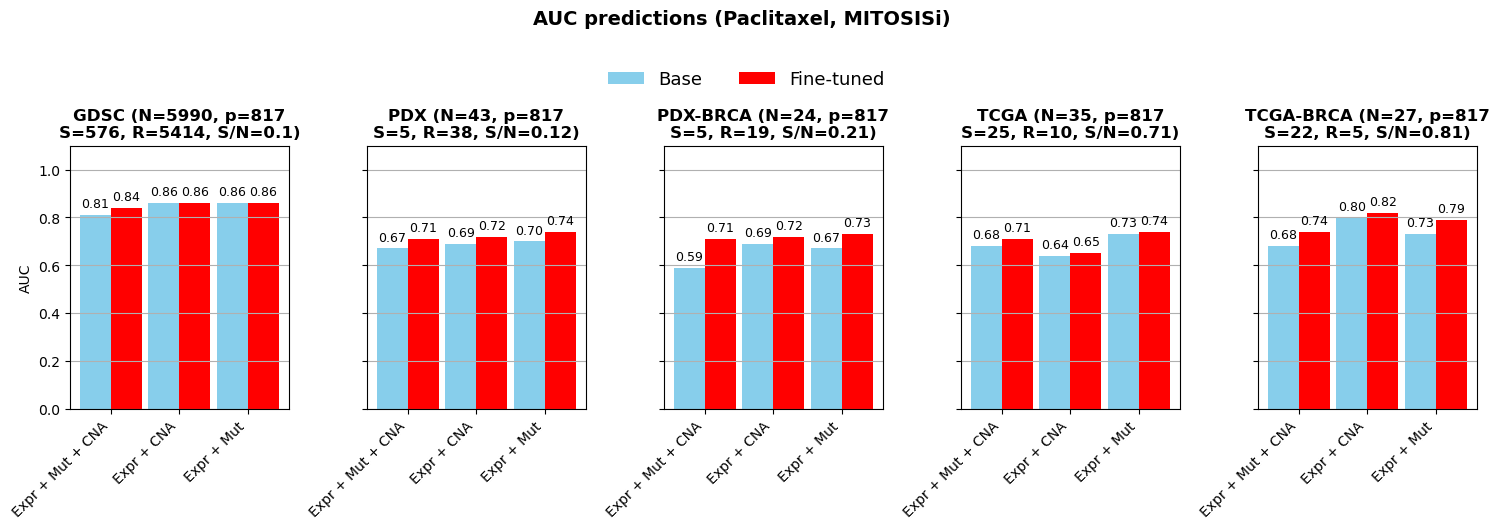

In [62]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Paclitaxel, MITOSISi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + "AUC Plot (Paclitaxel, MITOSISi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [63]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytspaclitaxel_pdx))})",
                                 f"AUCPR (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})",
                                 f"AUCPR (TCGA, N={str(len(Ytspaclitaxel_tcga))})",
                                 f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytspaclitaxel_pdx))})": f"PDX (N={str(len(Ytspaclitaxel_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})": f"PDX-BRCA (N={str(len(Ytspaclitaxel_pdx_brca))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytspaclitaxel_tcga))})": f"TCGA (N={str(len(Ytspaclitaxel_tcga))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_tcga_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=5990, p=817\nS=576, R=5414, S/N=0.1)","PDX (N=43, p=817\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=817\nS=5, R=19, S/N=0.21)","TCGA (N=35, p=817\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=817\nS=22, R=5, S/N=0.81)"
Data,,,,,
Expr + Mut + CNA,0.31,0.21,0.34,0.82,0.87
Expr + Mut + CNA (Fine-tuned),0.35,0.25,0.54,0.84,0.92
Expr + CNA,0.44,0.25,0.38,0.82,0.95
Expr + CNA (Fine-tuned),0.45,0.39,0.5,0.84,0.96
Expr + Mut,0.45,0.21,0.33,0.86,0.93
Expr + Mut (Fine-tuned),0.46,0.24,0.42,0.86,0.95


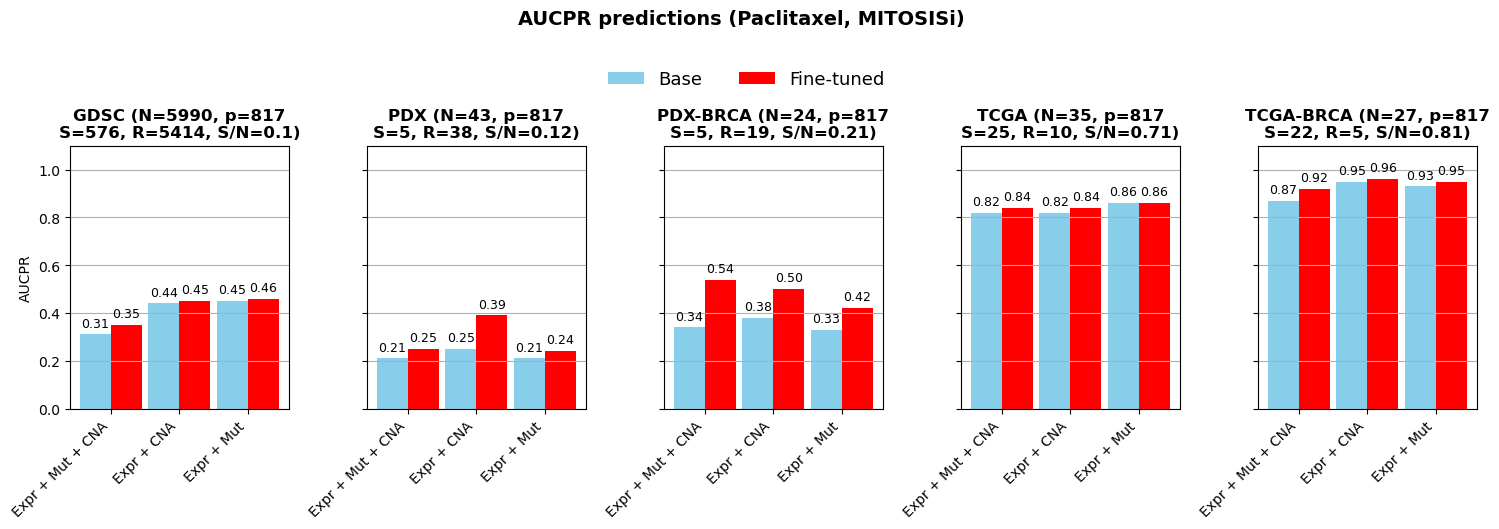

In [64]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Paclitaxel, MITOSISi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Paclitaxel, MITOSISi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [65]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/MITOSISi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy


In [66]:
# save predictions

file = open('GDSC_PDX_TCGA_MITOSISi_Paclitaxel_Predictions_Second_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (MITOSISi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (MITOSISi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Paclitaxel): {round(AUCTpaclitaxel_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Paclitaxel): {round(AUCTpaclitaxel_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca_aucpr,2)}\n")

file.close()

In [67]:
# get Gene symbols from Entrez ID

gene_list = mg.querymany(GDSCEv2.columns, 
                         species="human", 
                         scopes = "entrezgene",
                         field = "symbol",
                         as_dataframe=True)["symbol"]
gene_list

query
79875       THSD4
118788    PIK3AP1
2059         EPS8
10253       SPRY2
79887       PLBD1
           ...   
10217      CTDSPL
4082       MARCKS
51186      TCEAL9
90102      PHLDB2
126969    SLC44A3
Name: symbol, Length: 817, dtype: object

In [68]:
# change directory to read DEG file (Paclitaxel)

os.chdir(paclitaxel_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi/Paclitaxel


In [69]:
# read DEG file (Paclitaxel)

paclitaxel_DEGs_data = pd.read_excel("Limma Results (EnsemblID).xlsx")
paclitaxel_DEGs_data = paclitaxel_DEGs_data.set_index('ID', drop=True)
paclitaxel_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ID,,,,,,
ENSG00000088726,-1.268480,3.586764,-6.732562,6.381869e-11,6.685337e-07,14.205057
ENSG00000158023,-1.264376,3.490267,-6.709753,7.337251e-11,6.685337e-07,14.075779
ENSG00000158315,-1.153997,3.545926,-6.624056,1.235346e-10,7.503903e-07,13.593102
ENSG00000185650,-0.602372,3.685227,-6.183390,1.661383e-09,7.568847e-06,11.188236
ENSG00000019186,-1.493949,3.723812,-6.019371,4.220646e-09,1.538257e-05,10.326942


In [70]:
# get Gene symbols from Ensembl gene IDs

gene_symbols = mg.querymany(paclitaxel_DEGs_data.index, 
                              species="human", 
                              scopes = "ensembl.gene",
                              field = "symbol",
                              as_dataframe=True)["symbol"]

gene_symbols

1 input query terms found dup hits:	[('ENSG00000226506', 2)]
15 input query terms found no hit:	['ENSG00000291025', 'ENSG00000277796', 'ENSG00000176659', 'ENSG00000263574', 'ENSG00000168078', 'ENS


query
ENSG00000088726       TMEM40
ENSG00000158023      CFAP251
ENSG00000158315       RHBDL2
ENSG00000185650      ZFP36L1
ENSG00000019186      CYP24A1
                     ...    
ENSG00000108255       CRYBA1
ENSG00000147573       TRIM55
ENSG00000233746    LINC00656
ENSG00000181396       OGFOD3
ENSG00000168026       TTC21A
Name: symbol, Length: 18224, dtype: object

In [71]:
# merge Gene symbol column to the table

paclitaxel_merged_DEGs_data = pd.merge(paclitaxel_DEGs_data, pd.DataFrame(gene_symbols),  
                                       left_index=True, 
                                       right_index=True, 
                                       how='inner')

paclitaxel_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000088726,-1.268480,3.586764,-6.732562,6.381869e-11,6.685337e-07,14.205057,TMEM40
ENSG00000158023,-1.264376,3.490267,-6.709753,7.337251e-11,6.685337e-07,14.075779,CFAP251
ENSG00000158315,-1.153997,3.545926,-6.624056,1.235346e-10,7.503903e-07,13.593102,RHBDL2
ENSG00000185650,-0.602372,3.685227,-6.183390,1.661383e-09,7.568847e-06,11.188236,ZFP36L1
ENSG00000019186,-1.493949,3.723812,-6.019371,4.220646e-09,1.538257e-05,10.326942,CYP24A1


In [72]:
# subset DEGs in dataframe

filter = paclitaxel_merged_DEGs_data["symbol"].isin(gene_list)
paclitaxel_merged_DEGs_data = paclitaxel_merged_DEGs_data.loc[filter,:]

paclitaxel_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000184292,-3.170620,4.453405,-5.891180,8.629205e-09,0.000021,9.666892,TACSTD2
ENSG00000121316,-2.329463,4.803452,-5.875959,9.386483e-09,0.000021,9.589294,PLBD1
ENSG00000122861,-2.214223,4.812570,-5.604546,4.087951e-08,0.000068,8.233425,PLAU
ENSG00000162522,-0.980595,3.545471,-5.234588,2.778852e-07,0.000277,6.472082,NHSL3
ENSG00000173156,-1.480887,4.730098,-5.219082,3.004426e-07,0.000277,6.400490,RHOD


In [73]:
# export table for pathfindR analysis

os.makedirs(pathfindR_dir, exist_ok = True)

paclitaxel_merged_DEGs_data.to_csv(pathfindR_dir + "GDSC_Expression_Mutation_Filtered_DEGs_Table_MITOSISi_Paclitaxel_Second_Strategy.tsv",
                                   index = False,
                                   sep = "\t")

In [74]:
# change directory to read GDSC response dataset (MITOSISi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [75]:
# read GDSC response dataset but do not exclude paclitaxel (MITOSISi)

GDSCR = pd.read_csv("GDSC_response.MITOSISi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1
683665,0,-1.86219201025588,BI-2536,1,1,1
683665,0,-3.03887798334128,GW843682X,1,1,1


In [76]:
# GDSC response dataset

responses = GDSCR
responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1


In [77]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '949167', '998184', '1290771', '1298156', '1330948', '1330993',
       '1503364', '1509073', '1659818', '1659819'],
      dtype='object', name='sample_name', length=6360)

In [78]:
# filter GDSC expression and CNA datasets as to drugs
# filter selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls7 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls8 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls8, ls7]
GDSCMv2 = GDSCMv2.loc[ls8, ls7]
GDSCRv2 = GDSCRv2.loc[ls8, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls7]
PDXMpaclitaxel = PDXMpaclitaxel.loc[:,ls7]

TCGAEpaclitaxel = TCGAEpaclitaxel.loc[:,ls7]
TCGAMpaclitaxel = TCGAMpaclitaxel.loc[:,ls7]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (Mutation): {PDXMpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Paclitaxel (Expression): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (Mutation): {TCGAMpaclitaxel.shape}")

GDSC # of common samples and genes (Expression): (5990, 817)
GDSC # of common samples and genes (Mutation): (5990, 817)
GDSC # of common samples (Response): 6360

PDX # of common samples and genes for Paclitaxel (Expression): (43, 817)
PDX # of common samples and genes for Paclitaxel (Mutation): (43, 817)

TCGA # of common samples and genes for Paclitaxel (Expression): (35, 817)
TCGA # of common samples and genes for Paclitaxel (Mutation): (35, 817)


In [79]:
# subset sensitive and resistant cell lines in GDSC, PDX, and TCGA 

filter = (GDSCRv2["drug"] == "Paclitaxel")
paclitaxel_samples = GDSCRv2.loc[filter,:]

filter = (paclitaxel_samples["response"] == 0)
gdsc_paclitaxel_resistant_samples = paclitaxel_samples.loc[filter,:].index
gdsc_paclitaxel_sensitive_samples = paclitaxel_samples.loc[~filter,:].index

filter = (PDXRpaclitaxel["response"] == 0)
pdx_paclitaxel_resistant_samples = PDXRpaclitaxel.loc[filter,:].index
pdx_paclitaxel_sensitive_samples = PDXRpaclitaxel.loc[~filter,:].index

filter = (TCGARpaclitaxel["response"] == 0)
tcga_paclitaxel_resistant_samples = TCGARpaclitaxel.loc[filter,:].index
tcga_paclitaxel_sensitive_samples = TCGARpaclitaxel.loc[~filter,:].index

print(f"There are {gdsc_paclitaxel_sensitive_samples.shape[0]} paclitaxel sensitive cell lines in GDSC")
print(f"There are {gdsc_paclitaxel_resistant_samples.shape[0]} paclitaxel resistant cell lines in GDSC\n")

print(f"There are {pdx_paclitaxel_sensitive_samples.shape[0]} paclitaxel sensitive cell lines in PDX")
print(f"There are {pdx_paclitaxel_resistant_samples.shape[0]} paclitaxel resistant cell lines in PDX\n")

print(f"There are {tcga_paclitaxel_sensitive_samples.shape[0]} paclitaxel sensitive cell lines in TCGA")
print(f"There are {tcga_paclitaxel_resistant_samples.shape[0]} paclitaxel resistant cell lines in TCGA")

There are 26 paclitaxel sensitive cell lines in GDSC
There are 344 paclitaxel resistant cell lines in GDSC

There are 5 paclitaxel sensitive cell lines in PDX
There are 38 paclitaxel resistant cell lines in PDX

There are 25 paclitaxel sensitive cell lines in TCGA
There are 10 paclitaxel resistant cell lines in TCGA


In [80]:
paclitaxel_samples.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,-3.64728727366553,Paclitaxel,1,1,1
684055,0,-0.214086166599541,Paclitaxel,1,1,1
684057,0,0.0960911562819403,Paclitaxel,1,1,1


In [81]:
PDXRpaclitaxel.head(3)

,drug,response,ResponseCategory,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,exprs,CNA,mutations
sample_name,,,,,,,,,,,,,,,
X-1008,Paclitaxel,1,PR,paclitaxel,Tubulin,single,-77.6,90,-44.7625,90,90.0,90,1,1,1
X-1156,Paclitaxel,0,PD,paclitaxel,Tubulin,single,395.4,21,83.9,14,7.573426573426573,31,1,1,1
X-1172,Paclitaxel,0,PD,paclitaxel,Tubulin,single,321.8,20,-14.525000000000006,11,14.845744680851064,20,1,1,1


In [82]:
TCGARpaclitaxel.head(3)

,patient,cohort,drug,response,measure_of_response,exprs_sample_barcode,cna_sample_barcode,mut_sample_barcode
sample,,,,,,,,
TCGA-50-5068-01A,TCGA-50-5068,LUAD,Paclitaxel,0,Clinical Progressive Disease,TCGA-50-5068-01A-01R-1628-07,TCGA-50-5068-01A-01D-1624-01,TCGA-50-5068-01A-01D-1625-08
TCGA-53-7624-01A,TCGA-53-7624,LUAD,Paclitaxel,0,Clinical Progressive Disease,TCGA-53-7624-01A-11R-2066-07,TCGA-53-7624-01A-11D-2062-01,TCGA-53-7624-01A-11D-2063-08
TCGA-99-8033-01A,TCGA-99-8033,LUAD,Paclitaxel,0,Stable Disease,TCGA-99-8033-01A-11R-2241-07,TCGA-99-8033-01A-11D-2237-01,TCGA-99-8033-01A-11D-2238-08


In [83]:
# export sensitive and resistant cell lines in GDSC for pathfindR analysis

gdsc_df = pd.DataFrame(paclitaxel_samples["response"])
gdsc_df = gdsc_df.reset_index()
gdsc_df.rename(columns = {"index": "Sample", "response": "Response"}, inplace = True)

gdsc_df.to_csv(pathfindR_dir + "GDSC_MITOSISi_Paclitaxel_Samples_Second_Strategy.tsv",
               index = False,
               sep = "\t")

In [84]:
gdsc_df.head(3)

,Sample,Response
0,683665,0
1,684055,0
2,684057,0


In [85]:
# create and export experiment matrices for GDSC, PDX and TCGA for pathfindR analysis

filter = (GDSCE.index.isin(paclitaxel_samples.index))
gdsc_paclitaxel_df = GDSCE.loc[filter,:].transpose()

filter = (gdsc_paclitaxel_df.index.isin(GDSCEv2.columns))
gdsc_paclitaxel_exp_df = gdsc_paclitaxel_df.loc[filter,:]

gdsc_paclitaxel_exp_df.index = mg.querymany(gdsc_paclitaxel_exp_df.index,
                                            species="human",
                                            scopes = "entrezgene",
                                            field = "symbol",
                                            as_dataframe=True)["symbol"]

gdsc_paclitaxel_exp_df.to_csv(pathfindR_dir + "GDSC_Experiment_Matrix_MITOSISi_Paclitaxel_Second_Strategy.tsv",
                              sep = "\t")

In [86]:
gdsc_paclitaxel_exp_df.head(3)

,683665,684055,684057,684059,684062,684072,684681,687448,687562,687568,...,1331038,1331039,1331040,1331049,1331050,753552,905952,907789,907799,1330983
symbol,,,,,,,,,,,,,,,,,,,,,
ACTN1,-1.3206711957875388,-1.103845226286596,-1.2699003831873168,-0.3717935179646573,-1.0097600785392011,-0.6945620392040204,0.6854015673688795,0.4637946433111208,0.6913626395969674,0.8283685389749245,...,-2.579621450781637,-2.461199903370572,-1.14628611769758,-1.9058959647054148,-2.5641564642554227,0.5636558714766684,-1.561825498932797,-0.0028462460734283,-2.4840899426676613,0.069014927723014
ADA,1.436681017298101,-0.0722572533106381,0.564012775113484,-0.0863264421063415,0.6177088620774955,0.514199291986227,0.4382670639153719,0.3397351927488285,0.2198526659041163,1.3993480389802648,...,0.058074654895683,-2.14365499909463,0.1709063991761442,1.1581424576938413,1.2323717569526946,-0.4868176377295941,2.701213730609633,2.096967665513034,0.996741540299522,0.7239545101468587
ADM,-1.3526167748068398,-1.1195068187913624,-1.0859684209586615,0.4450460124658623,-1.1996106455883777,-1.13158014070773,0.5334344571379712,0.8512868074298221,0.1323372429559619,0.8636565180539437,...,-1.296621505987002,-1.451477827124993,-1.0204721717129115,-1.479016180642218,-1.4270126045460678,-0.3597667603399215,-1.4347459769311954,-0.3669546253874158,-1.20105849345812,-0.3335923630125136


In [87]:
# change directory to read DEG file (Paclitaxel)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi


In [88]:
# read DEG file (Paclitaxel)

paclitaxel_DEGs_filtered_data = pd.read_excel("MITOSISi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                              sheet_name = "Paclitaxel")
paclitaxel_DEGs_filtered_data = paclitaxel_DEGs_filtered_data.loc[:,["Gene.Symbol","logFC","adj.P.Val"]]

paclitaxel_DEGs_filtered_data.head()

,Gene.Symbol,logFC,adj.P.Val
0,TMEM40,-1.268480,6.685337e-07
1,CFAP251,-1.264376,6.685337e-07
2,RHBDL2,-1.153997,7.503903e-07
3,CYP24A1,-1.493949,1.538257e-05
4,TACSTD2,-3.170620,2.138124e-05


In [89]:
# export frequency table of DEGs (Paclitaxel)
# these genes are unionized DEGs including ones found for paclitaxel. 
# There is no "Frequency = 1" in the table since  paclitaxel-unique DEGs were excluded

filter = DEGs_filtered_data["Gene Symbol"].isin(paclitaxel_DEGs_filtered_data["Gene.Symbol"])
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_Expression_Mutation_DEGs_Freq_Table_MITOSISi_Paclitaxel_Second_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [90]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,PLS3,8
2,GPRC5A,7
3,TJP1,7
4,CXCR4,7
5,PLPP2,7
...,...,...
580,JAKMIP2,2
583,SLCO1B3,2
593,SPINT2,2
597,LAMC2,2


In [91]:
# export frequency table of DEGs (MITOSISi)
# these genes are unionized DEGs for all mitotic inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(gene_list)
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_PDX_TCGA_Expression_Mutation_DEGs_Freq_Table_MITOSISi_Second_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [92]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,PLS3,8
1,GMFG,7
2,GPRC5A,7
3,TJP1,7
4,CXCR4,7
...,...,...
991,TANC1,1
992,CD70,1
993,EFEMP2,1
994,TMEFF2,1
